In [2]:
import os
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

GPU is available
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
Using device: cuda


In [4]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)
classification_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5).to(device)
optimizer = AdamW(classification_model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Load and preprocess data
dataset_dir = r'C:\Users\yule_\M1Bert\THUCNews\浣撹偛'

def load_data(dataset_dir):
    texts = []
    filenames = []
    for filename in os.listdir(dataset_dir):
        file_path = os.path.join(dataset_dir, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            texts.append(text)
            filenames.append(filename)
    return texts, filenames

texts, filenames = load_data(dataset_dir)

In [6]:
# Convert text to vectors using BERT
def text_to_vector(text, tokenizer, model, max_len=100):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=max_len).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

news_vectors = [text_to_vector(text, tokenizer, model) for text in texts]

# Print the shape of the first vector (for check)
print(f"The shape of the first vector is: {news_vectors[0].shape}")

C:\Users\yule_\anaconda3\envs\my_env\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


The shape of the first vector is: (768,)


In [7]:
# Normalize the vectors
scaler = StandardScaler()
news_vectors_np = np.array(news_vectors)
news_vectors_np = scaler.fit_transform(news_vectors_np)

# Check and print the shape of the normalized vectors
print(f"The shape of the normalized vectors array is: {news_vectors_np.shape}")

The shape of the normalized vectors array is: (16896, 768)


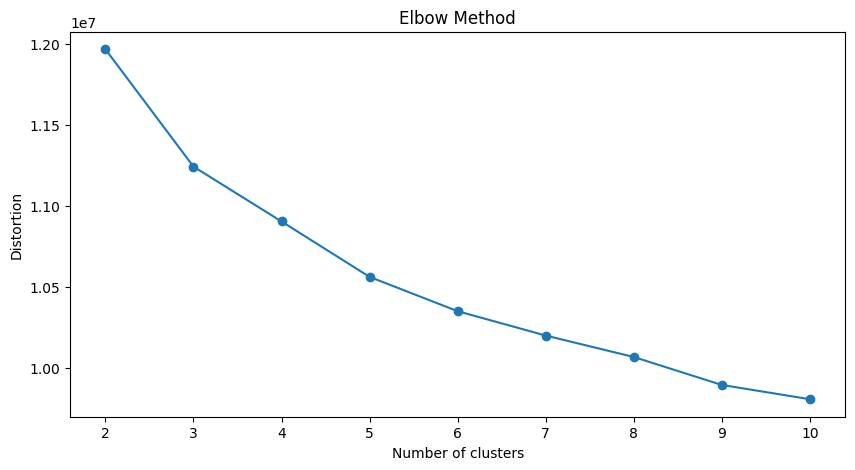

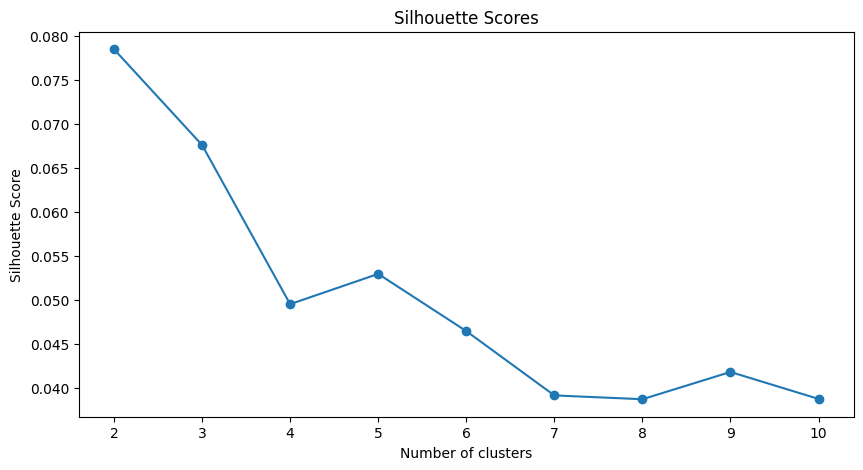

Optimal number of clusters: 2


In [8]:
# Determine the optimal number of clusters using the Elbow Method and Silhouette Score
def determine_optimal_clusters(data, max_clusters=10):
    distortions = []
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    # Plotting the Elbow Method
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    
    # Plotting Silhouette Scores
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Scores')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()
    
    optimal_clusters = np.argmax(silhouette_scores) + 2
    return optimal_clusters

optimal_clusters = determine_optimal_clusters(news_vectors_np)
print(f"Optimal number of clusters: {optimal_clusters}")

In [9]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(news_vectors_np)
labels = kmeans.labels_

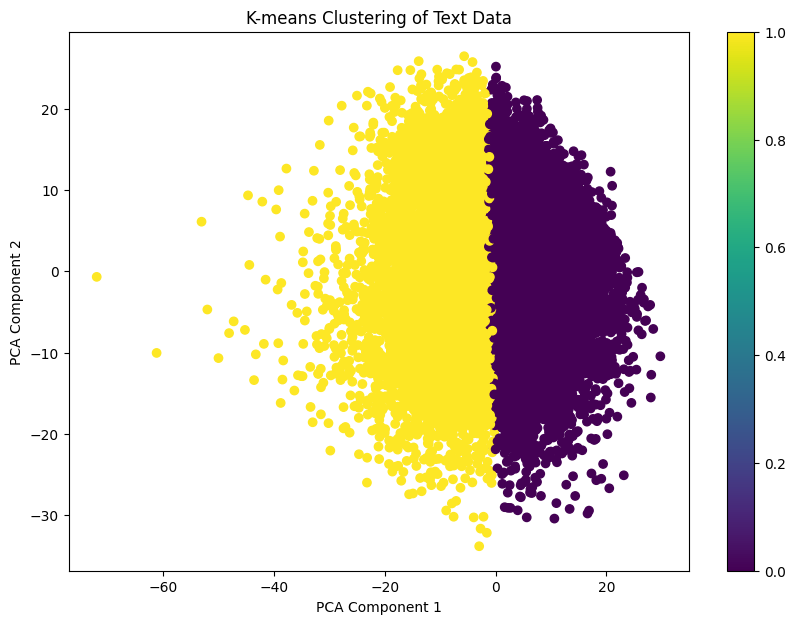

In [10]:
# Visualize the clusters
pca = PCA(n_components=2)
news_vectors_pca = pca.fit_transform(news_vectors_np)

plt.figure(figsize=(10, 7))
plt.scatter(news_vectors_pca[:, 0], news_vectors_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('K-means Clustering of Text Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

In [11]:
# Prepare data for classification
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=100)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

In [12]:
# Create DataLoader for the classification task
dataset = TensorDataset(input_ids, attention_mask, torch.tensor(labels))
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [13]:
# Training loop for classification
classification_model.train()
for epoch in range(3): 
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        # Ensure labels are of the correct dtype
        labels = labels.long()
        
        optimizer.zero_grad()
        outputs = classification_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/3], Loss: {loss.item()}")

Epoch [1/3], Loss: 0.42359960079193115
Epoch [2/3], Loss: 0.17345109581947327
Epoch [3/3], Loss: 0.13305334746837616


In [14]:
# Evaluation
classification_model.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = classification_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      9467
           1       0.99      0.94      0.96      7429

    accuracy                           0.97     16896
   macro avg       0.97      0.97      0.97     16896
weighted avg       0.97      0.97      0.97     16896



In [15]:
# Search function to find the most similar document
def search(query, texts, tokenizer, model):
    # query text to vector
    query_vec = text_to_vector(query, tokenizer, model)

    # calculate cos similarity
    similarities = cosine_similarity([query_vec], news_vectors)

    # find the index of the most similar document then return it
    most_similar_idx = np.argmax(similarities)
    return texts[most_similar_idx]

In [16]:
query = "nba" # key word
most_similar_text = search(query, texts, tokenizer, model)
print(f"Most similar text to the query: {most_similar_text}")

Most similar text to the query: 图文-NBA总冠军戒指黄金版在沪首发 
　　　　（体育）（3）篮球——NBA总冠军戒指“黄金版”在沪首发


